In [1]:
## Setup a program to find the parameters for a action sequence assuming q-learning

# Import packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from joblib import Parallel, delayed
from tqdm import tqdm

In [2]:
# import data

choices_full = np.loadtxt('full_action_set.csv', delimiter=',')
rewards_full = np.loadtxt('full_reward_set.csv', delimiter=',')

## STRUCTURE OF PARAMS
# params = [q0_init, q1_init, qupdate_1, qupdate_2 ... qupdate_n, policy_1, policy_2 ... policy_n]

class QLearning():

    # initialize the class
    def __init__(self, eps=1e-6):
        self.eps = eps

    # define the q update function
    def q_update(self, q, choice, reward, params):
        params = np.array(params)
        alpha = params[0]
        q[choice] = q[choice] + alpha*(reward - q[choice])
        return q

    # define the q learning function
    def q_learning(self, choices, rewards, params):
        qs = np.zeros((len(choices)+1,2))
        qs[0,:] = params[:2]
        for i in range(len(choices)):
            qs[i+1,:] = self.q_update(qs[i,:],int(choices[i]), rewards[i], params[2:])
        return qs

    # define the policy function
    def policy(self,q,params):
        p = np.exp(q/params[-1])
        p = p / np.sum(p, axis=1)[:,None]
        return p
    
    # calculate the probability of choosing each action based on history
    def prob_choice(self, choices, rewards, params):
        qs = self.q_learning(choices, rewards, params)
        ps = np.clip(self.policy(qs,params), self.eps, 1-self.eps)
        return ps
    
    # define the regularizer
    def regularizer(self, params):
        return 0

    # calculate the negative log likelihood
    def nll(self, params, choices, rewards):
        lls = []
        for i in range(len(choices)):
            ps = self.prob_choice(choices[i], rewards[i], params)[:-1,:]
            lls.append(np.sum(choices[i] * np.log(ps[:,1]) + (1-choices[i]) * np.log(ps[:,0])))
        return -np.sum(lls)
    
    # calculate the regularized negative log likelihood
    def nll_reg(self, params, choices, rewards, lambda_reg):
        return self.nll(params, choices, rewards) + self.regularizer(params) * lambda_reg
    
    # fit the model to the data using differential evolution
    def fit(self, choices, rewards, params_init, lambda_reg=0, **kwargs):
        res = opt.differential_evolution(
            self.nll_reg,
            args=(choices, rewards, lambda_reg),**kwargs)
        return res
    
    # define a function to fit the model to a single subject
    def fit_subject(self, subject, choices, rewards, params_init, lambda_reg=0, **kwargs):
        res = self.fit(
            choices[subject:subject+1], rewards[subject:subject+1], params_init, **kwargs
            )
        return res.x

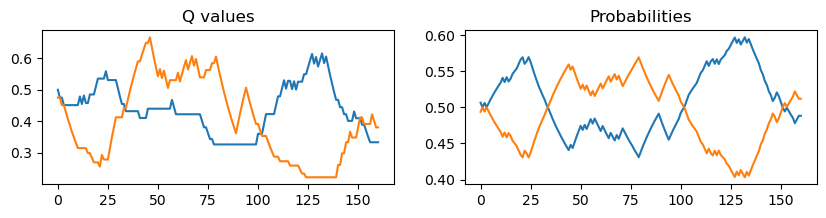

differential_evolution step 1: f(x)= 525.557
differential_evolution step 2: f(x)= 525.557
differential_evolution step 3: f(x)= 525.557
differential_evolution step 4: f(x)= 524.121
differential_evolution step 5: f(x)= 517.993
differential_evolution step 6: f(x)= 517.993
differential_evolution step 7: f(x)= 517.993
differential_evolution step 8: f(x)= 517.993
differential_evolution step 9: f(x)= 517.993
differential_evolution step 10: f(x)= 517.993
differential_evolution step 11: f(x)= 517.654
differential_evolution step 12: f(x)= 514.187
differential_evolution step 13: f(x)= 514.187
differential_evolution step 14: f(x)= 514.187
differential_evolution step 15: f(x)= 513.312
differential_evolution step 16: f(x)= 513.312
differential_evolution step 17: f(x)= 513.312
differential_evolution step 18: f(x)= 513.312
differential_evolution step 19: f(x)= 513.312
differential_evolution step 20: f(x)= 513.312
differential_evolution step 21: f(x)= 511.526
differential_evolution step 22: f(x)= 511.5

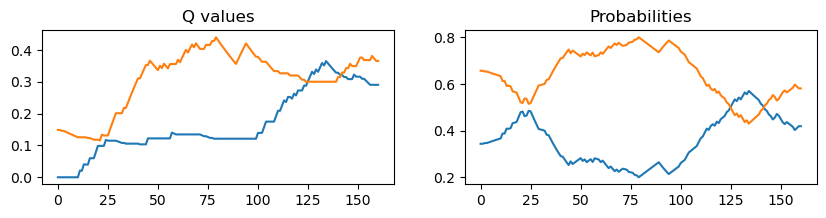

In [3]:
# initialize the class
qlearn = QLearning()

# define a guess for the parameters
params_init = [0.5, 0.5, 0.05, 1.]
qs = qlearn.q_learning(choices_full[0], rewards_full[0], params_init)
ps = qlearn.prob_choice(choices_full[0], rewards_full[0], params_init)

fig,ax = plt.subplots(1,2, figsize=(10,2))
ax[0].plot(qs)
ax[0].set_title('Q values')
ax[1].plot(ps)
ax[1].set_title('Probabilities')
plt.show()

# fit the model to the data
res = qlearn.fit(
    choices_full[:5], rewards_full[:5], params_init, lambda_reg=0,
    bounds=[(0,1), (0,1), (0,1),(0.1,100)], 
    maxiter=1000, popsize=100, tol=1e-3, disp=True)

print("Best fit parameters: ", res.x)

# plot the results
qs = qlearn.q_learning(choices_full[0], rewards_full[0], res.x)
ps = qlearn.prob_choice(choices_full[0], rewards_full[0], res.x)

fig,ax = plt.subplots(1,2, figsize=(10,2))
ax[0].plot(qs)
ax[0].set_title('Q values')
ax[1].plot(ps)
ax[1].set_title('Probabilities')
plt.show()


In [9]:
# initialize the class
qlearn = QLearning()

# define a guess for the parameters
params_init = [0.5, 0.5, 0.05, 1.]

# parallelize the fitting of single subjects
res = Parallel(n_jobs=4)(
    delayed(qlearn.fit_subject)(
        subject, choices_full, rewards_full, params_init, lambda_reg=0,
        bounds=[(0,1), (0,1), (0,1),(0.01,100)],
        maxiter=1000, popsize=100, tol=1e-3, disp=False
        ) for subject in tqdm(range(132)))


In [6]:
res = np.loadtxt('qlearn_params.csv', delimiter=',')

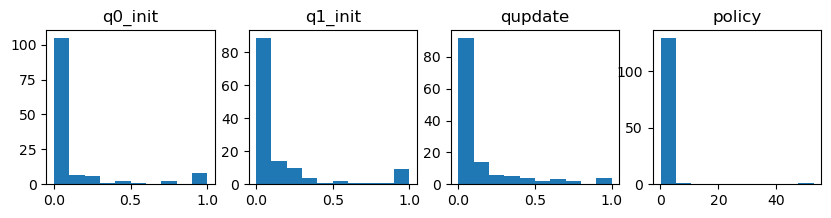

In [7]:
res = np.array(res)

# plot histograms of the parameters
fig,ax = plt.subplots(1,4, figsize=(10,2))
ax[0].hist(res[:,0])
ax[0].set_title('q0_init')
ax[1].hist(res[:,1])
ax[1].set_title('q1_init')
ax[2].hist(res[:,2])
ax[2].set_title('qupdate')
ax[3].hist(res[:,3])
ax[3].set_title('policy')
plt.show()

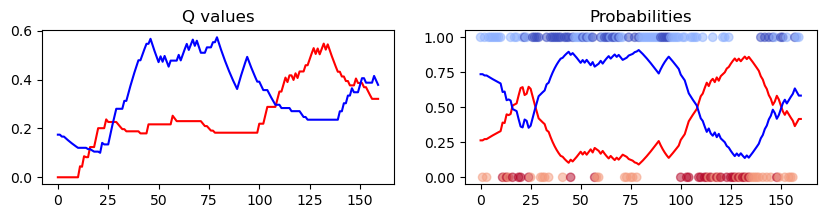

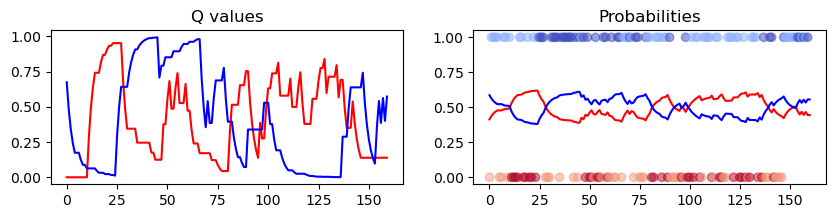

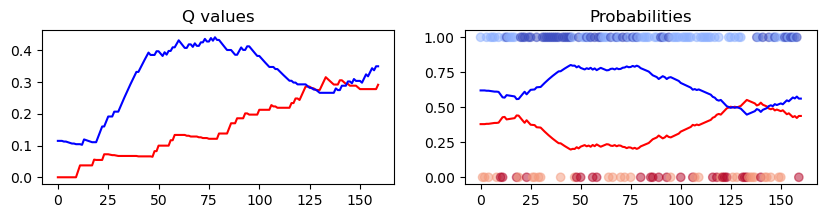

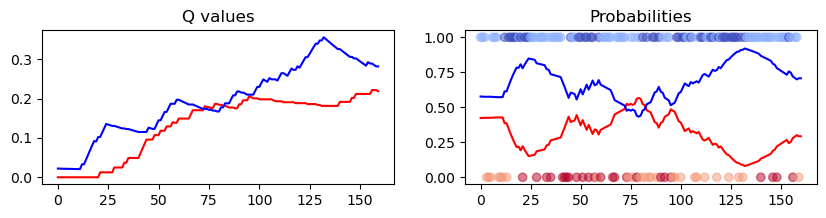

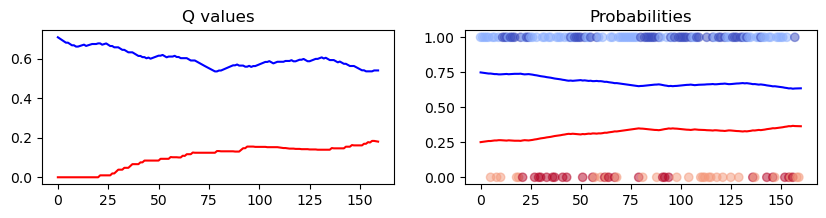

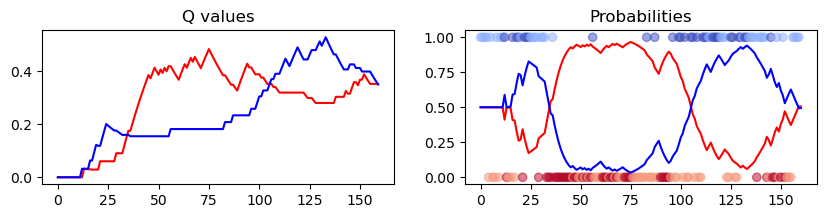

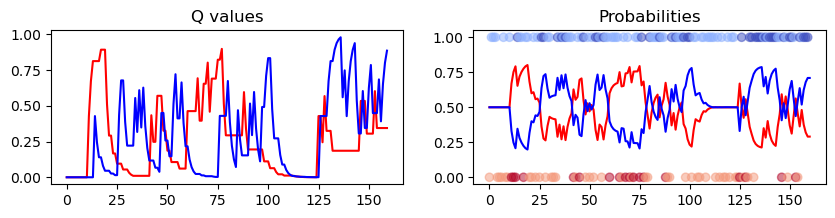

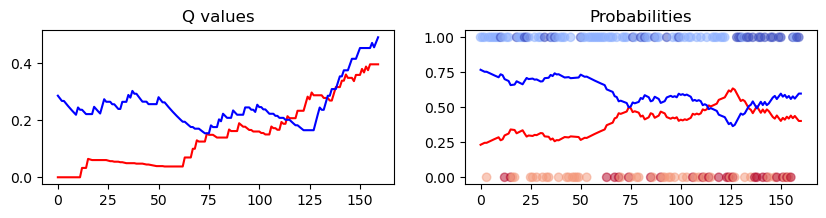

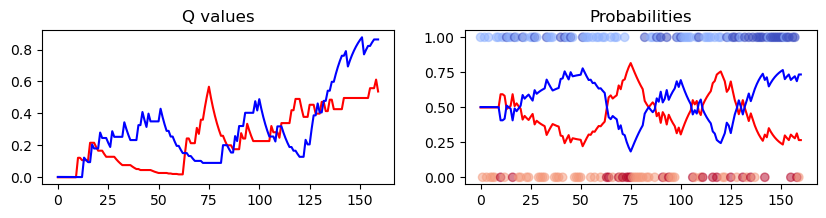

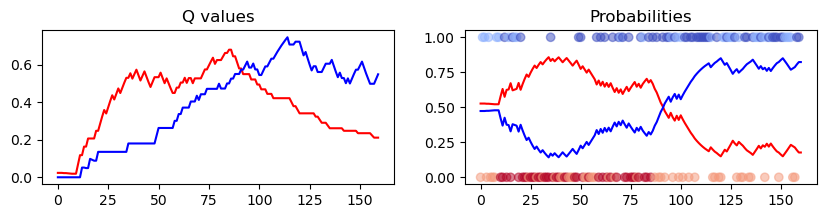

In [15]:
for i in range(10):
    # plot the results
    qs = qlearn.q_learning(choices_full[i], rewards_full[i], res[i])
    ps = qlearn.prob_choice(choices_full[i], rewards_full[i], res[i])

    fig,ax = plt.subplots(1,2, figsize=(10,2))
    ax[0].plot(qs[:-1,0], color='red')
    ax[0].plot(qs[:-1,1], color='blue')
    ax[0].set_title('Q values')
    ax[1].plot(ps[:,0], color='red')
    ax[1].plot(ps[:,1], color='blue')
    c=(((rewards_full[i]+1)*(1-2*choices_full[i]))+2)/4
    ax[1].scatter(np.arange(len(choices_full[i])), choices_full[i], c=plt.cm.coolwarm(c),alpha=0.5)
    ax[1].set_title('Probabilities')
    plt.show()

In [234]:
# optimize the parameters
init_params = np.array([0., 0., 0.05, 1.])

# global optimization using genetic algorithm
res = opt.differential_evolution(
    qlearn.nll_reg,
    bounds=[(0,1), (0,1), (0,1),(0.1,100)], 
    args=(choices_full[:1], rewards_full[:1], 0.1),
    maxiter=1000, popsize=100, tol=1e-3,
    disp=True
    )

print(res.x)

differential_evolution step 1: f(x)= 96.0156
differential_evolution step 2: f(x)= 96.0156
differential_evolution step 3: f(x)= 91.957
differential_evolution step 4: f(x)= 91.957
differential_evolution step 5: f(x)= 91.957
differential_evolution step 6: f(x)= 91.957
differential_evolution step 7: f(x)= 90.7594
differential_evolution step 8: f(x)= 90.7594
differential_evolution step 9: f(x)= 90.7594
differential_evolution step 10: f(x)= 90.7594
differential_evolution step 11: f(x)= 90.7594
differential_evolution step 12: f(x)= 90.6396
differential_evolution step 13: f(x)= 89.0609
differential_evolution step 14: f(x)= 89.0609
differential_evolution step 15: f(x)= 89.0609
differential_evolution step 16: f(x)= 89.0609
differential_evolution step 17: f(x)= 89.0326
differential_evolution step 18: f(x)= 88.6317
differential_evolution step 19: f(x)= 88.6317
differential_evolution step 20: f(x)= 88.6317
differential_evolution step 21: f(x)= 88.6317
differential_evolution step 22: f(x)= 87.9032
d

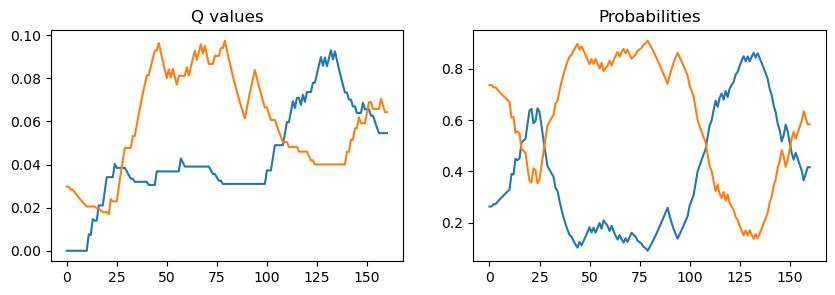

In [235]:
qs = qlearn.q_learning(choices_full[0], rewards_full[0], res.x)
ps = qlearn.prob_choice(choices_full[0], rewards_full[0], res.x)
fig,ax = plt.subplots(1,2, figsize=(10,3))
ax[0].plot(qs*res.x[-1])
ax[0].set_title('Q values')
ax[1].plot(ps)
ax[1].set_title('Probabilities')
plt.show()

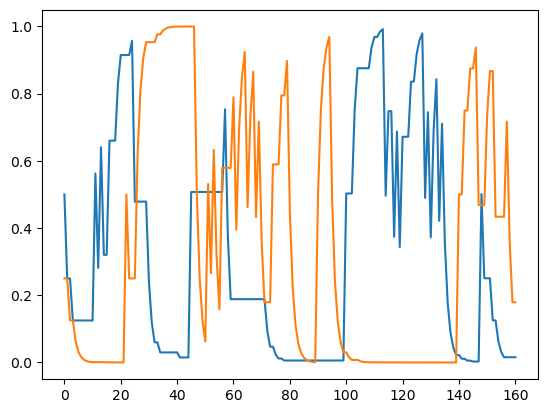

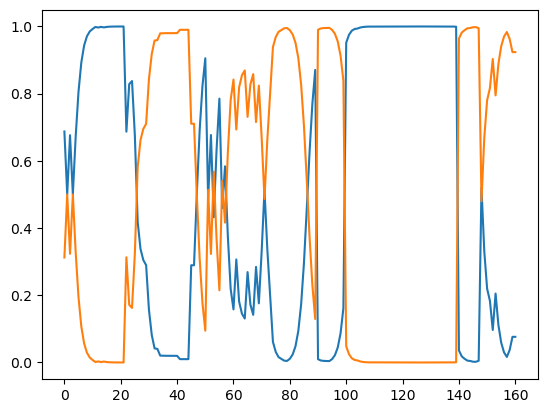

In [50]:
plt.plot(qs)
plt.show()
plt.plot(ps)
plt.show()

In [ ]:
# def ar_policy(q):
#     q = q.T
#     q = np.clip(q, 1e-6, 1-1e-6)
#     p0 = q[0]*(3-q[1])/(3*q[0] + 3*q[1] - 2 * q[0] * q[1])
#     p1 = 1 - p0
#     return np.array([p0, p1]).T